### Test the trained network

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, Callback
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


### Hyperparameters
batch_size = 1 
k = 4
d = 3


/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Network to load

In [2]:
timestamp = "2018-05-28_23:22"

epoch = 50

- Load gmm params

In [3]:
import numpy as np

In [4]:
filename=timestamp + "-gmmParams.npz"

with np.load(filename) as data:
    phi = data["phi"]
    mu = data["mu"]
    sigma = data["sigma"]
    

In [5]:
phi = K.constant(phi)
mu = K.constant(mu)
sigma = K.constant(sigma)

In [6]:
K.eval(phi)

array([0.25017795, 0.24993297, 0.24993259, 0.24995646], dtype=float32)

In [7]:
K.eval(mu)

array([[1.2303193, 1.2303193, 1.2303193],
       [1.2302781, 1.2302781, 1.2302781],
       [1.2302703, 1.2302703, 1.2302703],
       [1.2302772, 1.2302772, 1.2302772]], dtype=float32)

In [8]:
K.eval(sigma)

array([[[1.2155795 , 0.2898179 , 1.2124854 ],
        [0.2898179 , 0.07950871, 0.27077967],
        [1.2124854 , 0.27077967, 1.2418908 ]],

       [[1.215524  , 0.28976494, 1.2124406 ],
        [0.28976494, 0.0794884 , 0.27072647],
        [1.2124406 , 0.27072647, 1.2418607 ]],

       [[1.2155112 , 0.2897507 , 1.2124361 ],
        [0.2897507 , 0.07948116, 0.27071616],
        [1.2124361 , 0.27071616, 1.241861  ]],

       [[1.2155223 , 0.2897625 , 1.212441  ],
        [0.2897625 , 0.07948695, 0.27072525],
        [1.212441  , 0.27072525, 1.2418624 ]]], dtype=float32)

- Plot loss history

In [9]:
def plotHistory(loss_array, save=False, savename=timestamp+"-lossGraph.png"):
    fig = plt.figure()
    ax = fig.add_subplot(111)    # The big subplot
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.plot(loss_array)
    
    if save:
        plt.savefig(savename)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
filename = timestamp + "-history.npz"
with np.load(filename) as data:
    history = data["history"]

history = history.ravel()[0]["loss"]

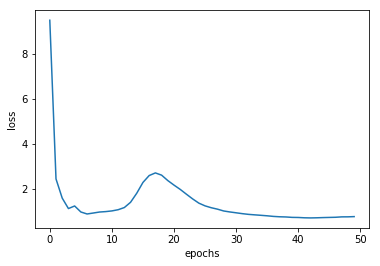

In [12]:
plotHistory(history, save=True)

- Network definition for testing

In [13]:
### Define compresion network

input_data = Input(batch_shape=(batch_size,120), name='input_placeholder')

encoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

layer_lowdim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(layer_lowdim)
decoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)



### Define similarity metrics

def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

### Obtain "z"
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([layer_lowdim, layer_cossim, layer_relativeEuc])


### Sample energy as a lambda function at the end
def computeEnergy(z_i):
    inside_sum = tf.zeros(()) 
    for cluster in range(k):
        diff = tf.reshape(z_i - mu[cluster], (1,-1))   ### (1,3)
        diff_t = tf.reshape(diff, (-1,1)) #diff.reshape(-1,1)   ### (3,1)

        sigma_inv = tf.linalg.inv(sigma[cluster]) ### (3,3)
        
        exp_term = tf.exp(-0.5 * tf.matmul(diff, tf.matmul(sigma_inv, diff_t)))    ### (1,1)

        denom = tf.sqrt(tf.linalg.det(2 * np.pi * sigma[cluster]))
        
        inside_sum += phi[cluster] * (exp_term / denom)   ### (1,1)
        
        
    inside_sum = tf.reshape(inside_sum, ())
    
    sample_energy = -tf.log(inside_sum + 1e-6) 
    
    
    return sample_energy

def energyCalc(yTrue, yPred):
    
    z = layer_concat

    return computeEnergy(z)


layer_energy = Lambda(computeEnergy,
                      name='sample_energy')([layer_concat])




eval_net = Model(input=input_data, outputs=layer_energy)

eval_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_placeholder (InputLayer)  (1, 120)             0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1, 60)              7260        input_placeholder[0][0]          
__________________________________________________________________________________________________
dense_2 (Dense)                 (1, 30)              1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (1, 10)              310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("sa..., inputs=Tensor("in...)`


- Load trained weights

In [14]:
filename = timestamp + "-modelsave_weights-epochs{}.h5".format(epoch)
eval_net.load_weights(filename, by_name=True)

- Load dataset

In [15]:
import numpy as np

In [16]:
with np.load('kdd99_test-randomState_None.npz') as data:  ### kdd99_test
    x_test = data['x_test']

In [17]:
normal_data = x_test[np.where(x_test[:,-1] == 1)]

In [18]:
anomaly_data = x_test[np.where(x_test[:,-1] == 0)]

In [19]:
normal_data.shape

(198366, 120)

In [20]:
anomaly_data.shape

(48645, 120)

- Obtain sample energies

In [21]:
eval_net.predict(normal_data[-100:], batch_size=1, verbose=1)  

100/100 [==============================] - 0s 3ms/step


array([13.815511 , 13.815511 , 13.815511 , 13.815511 ,  3.368639 ,
       13.815511 , 13.815511 , 13.815511 , 13.815511 , 13.815511 ,
        3.3267875, 13.815511 , 13.815511 ,  3.413237 , 13.815511 ,
       13.815511 ,  3.2404416, 13.815511 , 13.815511 , 13.815511 ,
       13.815511 , 13.815511 ,  3.2427187, 13.815511 , 13.815511 ,
       13.815511 , 13.815511 , 13.815511 , 13.815511 ,  3.2683754,
       13.815511 , 13.815511 , 13.815511 , 13.815511 ,  3.3727894,
       13.815511 , 13.815511 , 13.815511 , 13.815511 , 13.815511 ,
       13.815508 , 13.815511 ,  3.9180603, 13.815511 , 13.815511 ,
        3.3753772, 13.815511 , 13.815511 , 13.815511 , 13.815511 ,
       13.815511 ,  3.4115129, 13.815511 , 13.815511 , 13.815511 ,
       13.815511 , 13.815511 , 13.815511 ,  3.21052  , 13.815511 ,
       13.815511 ,  3.2266018, 13.815511 , 13.815511 , 13.815511 ,
       13.815511 , 13.815511 ,  3.0825908, 13.815511 , 13.815511 ,
        3.417551 , 13.815511 , 13.815462 , 13.815511 ,  3.1309